In [1]:
import numpy as np
import networkx as nx
!pip install torch_geometric
import torch_geometric
from torch_geometric.utils import to_networkx
from IPython.display import clear_output
import torch
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
sns.set_theme()
clear_output()

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
from torch_geometric.nn import GraphConv, TopKPooling, TransformerConv, GATConv
from torch_geometric.nn import global_mean_pool, global_max_pool, global_add_pool
from torch.nn import Linear, BatchNorm1d, ModuleList
import torch.nn.functional as F
from sklearn.metrics import confusion_matrix, f1_score, \
    accuracy_score, precision_score, recall_score, roc_auc_score

In [4]:
#dataset = torch_geometric.datasets.TUDataset(root = "/Users/porlu/Documents/University_courses/knowl_repr", name = "PROTEINS", cleaned = True, use_edge_attr = True, use_node_attr  = True)
dataset = torch_geometric.datasets.TUDataset(root = "knowl_repr", name = "PROTEINS", cleaned = True, use_edge_attr = True, use_node_attr  = True)

clear_output()

In [5]:
device = torch.device('cuda' if torch.cuda.is_available() else "cpu")

In [44]:
from torch_geometric.data import DataLoader

test_ratio = 0.3 # Ratio for splitting dataset
batch_size = 64
length = 975
start_of_ones = 632

test_dataset = dataset[:int(test_ratio * start_of_ones)] + dataset[start_of_ones :start_of_ones +  int(test_ratio * (length - start_of_ones))]
# train set is balanced by hands
train_dataset = dataset[int(test_ratio * start_of_ones):start_of_ones] + dataset[start_of_ones + int(test_ratio * (length - start_of_ones)):] + dataset[start_of_ones + int(test_ratio * (length - start_of_ones)):]
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle = True)

In [61]:
class SimpleModel(torch.nn.Module):
  def __init__(self, dim) -> None:
      super().__init__()
      self.dim = dim

      self.conv1 = GraphConv(4, self.dim)
      self.conv2 = GATConv(self.dim, self.dim, dropout=0.6, heads=16)
      self.gat1 = GraphConv(self.dim * 16, self.dim, dropout = 0.5)

      self.fc1 = Linear(self.dim, self.dim)
      self.fc2 = Linear(self.dim, 2)

  def forward(self, x, edge_index, batch, edge_weight=None):
        x = F.relu(self.conv1(x, edge_index, edge_weight))
        x = F.dropout(x, p=0.5, training=self.training)
        x = F.relu(self.conv2(x, edge_index, edge_weight))
        x = F.relu(self.gat1(x, edge_index, edge_weight))

        x = global_add_pool(x, batch)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.fc2(x)
        return x

In [ ]:

#model = Net(64, 4, 2).to(device)
#model = GCN_1(4, 64).to(device)
model = SimpleModel(64).to(device)
#%% Loss and Optimizer
loss_fn = torch.nn.CrossEntropyLoss() # weights remove disbalance
optimizer = torch.optim.Adam(model.parameters())

def train(epoch):
    # Enumerate over the data
    all_preds = []
    all_labels = []
    for data in tqdm(train_loader):
        data = data.to(device)

        x, edge_index, batch = data.x, data.edge_index, data.batch
        labels = data.y

        optimizer.zero_grad()

        pred = model(x,edge_index, batch)
        loss = loss_fn(pred.float(), labels)

        loss.backward()
        optimizer.step()

        all_preds.append(np.argmax(pred.cpu().detach().numpy(), axis=1))
        all_labels.append(labels.cpu().detach().numpy())

    all_preds = np.concatenate(all_preds).ravel()
    all_labels = np.concatenate(all_labels).ravel()
    calculate_metrics(all_preds, all_labels, epoch, "train")
    return loss

def test(epoch):
    all_preds = []
    all_labels = []
    for data in test_loader:
        data = data.to(device)

        x, edge_index, batch = data.x, data.edge_index, data.batch
        labels = data.y

        pred = model(x,edge_index, batch)

        loss = loss_fn(pred.float(), labels)

        all_preds.append(np.argmax(pred.cpu().detach().numpy(), axis=1))
        all_labels.append(labels.cpu().detach().numpy())

    all_preds = np.concatenate(all_preds).ravel()
    all_labels = np.concatenate(all_labels).ravel()
    acc = calculate_metrics(all_preds, all_labels, epoch, "test")
    accuracy_val.append(acc)
    return loss

def calculate_metrics(y_pred, y_true, epoch, type):
    print(f"\n Confusion matrix: \n {confusion_matrix(y_pred, y_true)}")
    print(f"F1 Score: {f1_score(y_pred, y_true)}")
    print(f"Accuracy: {accuracy_score(y_pred, y_true)}")
    print(f"Precision: {precision_score(y_pred, y_true)}")
    print(f"Recall: {recall_score(y_pred, y_true)}")
    return accuracy_score(y_pred, y_true)
losses_train = []
losses_val = []
accuracy_val = []
for epoch in range(80):
        # Training
        model.train()
        loss = train(epoch=epoch)
        losses_train.append(loss.item())
        loss = loss.detach().cpu().numpy()
        print(f"Epoch {epoch} | Train Loss {loss}")

        # Testing
        model.eval()
        if epoch % 5 == 0:
            loss = test(epoch=epoch)
            losses_val.append(loss.item())
            loss = loss.detach().cpu().numpy()
            print(f"Epoch {epoch} | Test Loss {loss}")

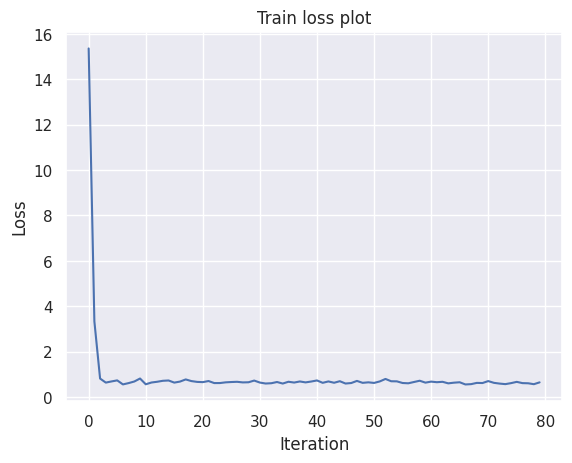

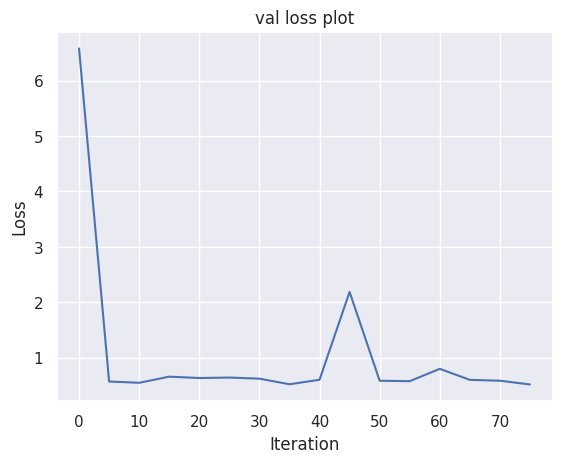

Text(0, 0.5, 'accuracy')

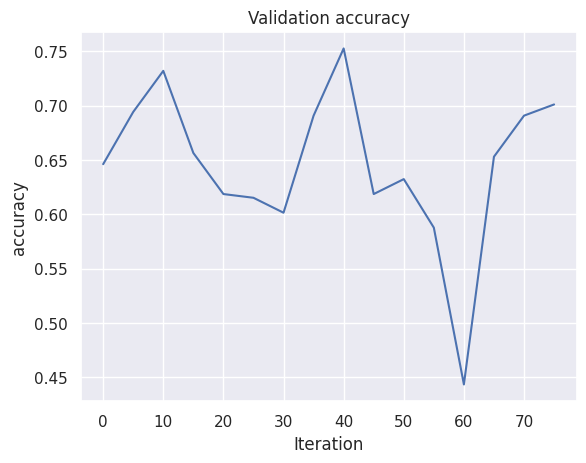

In [65]:
ax = plt.subplot()
sns.lineplot(x=range(80), y=losses_train ,ax = ax)
ax.set_title("Train loss plot")
ax.set_xlabel("Iteration")
ax.set_ylabel("Loss")
plt.show()
ax = plt.subplot()
sns.lineplot(x=[i*5 for i in range(16)], y=losses_val ,ax = ax)
ax.set_title("val loss plot")
ax.set_xlabel("Iteration")
ax.set_ylabel("Loss")
plt.show()
ax = plt.subplot()
sns.lineplot(x=[i*5 for i in range(16)],y=accuracy_val ,ax = ax)
ax.set_title("Validation accuracy")
ax.set_xlabel("Iteration")
ax.set_ylabel("accuracy")